# Optimization final project

Kenwan Cheung, Joan Lee, Chantel Miller, Anthony Smaniotto.

### Background: 
As computing power and data size have grown exponentially in the past decade there has been a massive improvement in the accuracy and complexity of neural networks. While theorized by Minksy and others in the 60s, it was the breakthrough in the early 1980s by Geoffrey Hinton and his co-authors with the development of “back-propogation” that enabled development of deeper networks. When combined with the improvements in raw computing power and scale of data, we’ve seen neural networks become proficient at a variety of tasks, from image recognition to beating the best human players in the game of Go.

### Problem: 

As neural networks have gotten deeper and more complex, parameter estimation and the relevant optimization methodology is now a critical step to building neural networks.

At a simple level, neural networks could be thought of as a host of regressions set up in m-layers. We must figure out the weights of each one of those connections. In the simple example below with just one set of hidden layers, The number of parameters to be estimated is calculated by the sum of the product of the numbers of nodes in connected layers. Parameters: (3×4)+(4×2)=20. 

We can intuitively see how quickly the parameter estimation process grows. Many of the advances in the past decade have come hand in hand with advances in the optimization methods used to optimize the parameter estimation and improve time to convergence. 

### Our goal: 

Our team will seek to hand-code neural networks while implementing several of the most common optimization methods such as: stochastic gradient descent, Adagrad, ADAM. We will seek to gain a deeper understanding over how they converge by leveraging the age old Francisco™ method: simulation, development of our own functions, and visualization. We will complete this in Python.


In [2]:
# IMPORT PACKAGES

# Import relevant packages

%matplotlib inline
from sklearn import datasets, neighbors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, GridSearchCV,KFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from imutils import paths
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation, Conv2D, ZeroPadding2D
from keras.optimizers import RMSprop, adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils,to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K
from keras.metrics import binary_accuracy,binary_crossentropy
from tqdm import tqdm
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.regularizers import l2 # L2-regularisation
from keras.layers.normalization import BatchNormalization # batch normalisation
from sklearn import svm
import random 
import argparse
import datetime
import imutils
import cv2
import os
import re
import shutil
from IPython.display import Image
K.set_image_dim_ordering('th')


C:\Users\Joan\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Joan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Part 1

Simulation of the dataset.

Let's begin by simulating a simple data generation process.

Let's simulate a multivariate normal distribution. We might use a logistic regression in this scenario.

In [3]:
# set seed
np.random.seed(12)
n = 10000

x_1 = np.random.multivariate_normal([0, 0], [[1, .75],[.75, 1]], n)
x_2 = np.random.multivariate_normal([1, 4], [[2, .75],[.75, 2]], n)
x_3 = np.random.multivariate_normal([2, 8], [[3, .75],[.75, 3]], n)

simulated_separableish_features = np.vstack((x_1, x_2, x_3)).astype(np.float32)
y = np.hstack((np.zeros(n),
               np.ones(n),
              np.ones(n)+1))


In [4]:
print(x_1.shape,x_2.shape,x_3.shape)
print(y.shape)

(10000, 2) (10000, 2) (10000, 2)
(30000,)


Text(0.5,1,'simulated data multivariate')

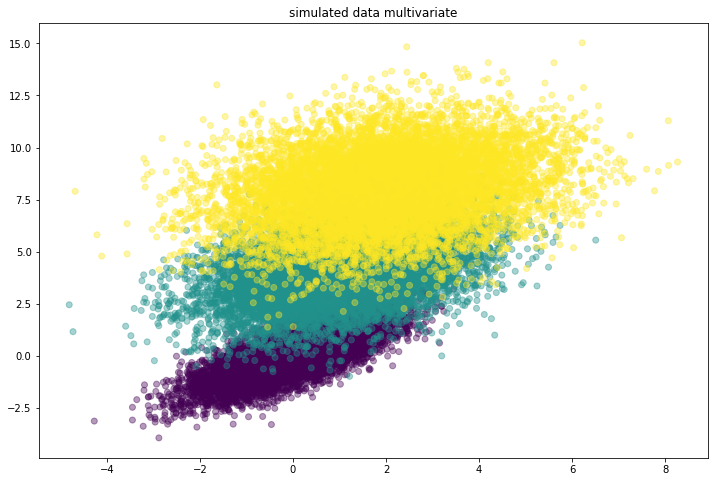

In [5]:
plt.figure(figsize=(12,8))
plt.scatter(simulated_separableish_features[:, 0], simulated_separableish_features[:, 1],
            c = y, alpha = .4)
plt.title("simulated data multivariate")

# Part 2

Let's begin by setting up a function for a small NN.

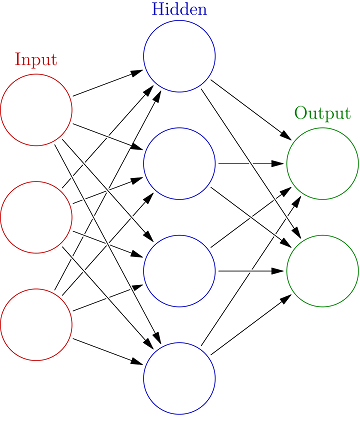

In [6]:
Image("../optimization_final/raw/neural_network_hidden.png")

### Discussion of how to build a neural net.

Neural  nets at their core are typically built around sigmoid functions. The biggest discrepancy with a more traditional approach would be the rise of "hidden" layers whose weights we are trying to calculate.

    1) Input layer weights - just like we would for a logistic regression. 
    2) We develop a hidden layer around some "activation function". Originally these were sigmoid functions, but advancements have been made to move away from the sigmoid (how our own neurons work), to something like the ReLu.
    3) Go from hidden layer to outputs layer.
    4) Translate output layer to output values with a probability distribution. Typically softmax. 

In a traditional logistic regression, the optimization occurs around the log-likelihood, which we try and maximize given a series of coefficients.

#### Log-Likelihood optimization
$ll =  \sum_{i=1}^N y_i\beta^Tx_i - log(1+e^{\beta^Tx_i})$


#### Neural network optimization
We can think about neural nets as something similar. We must optimize the errors around a particular set of weights for each layer. We do this iteratively until we reach some threshold of tolerance.



# Building our networks

In order for us to build our network, we'll need several things:

    1) initialize arrays with the correct size.
    2) set up an activation fx
    3) set up a output function
    4) set up a loss function
    5) set up back propogation / gradient passing to allow the network to adjust the next iteration. In a sense we're calculating the error as each coefficient changes. Or the derivative of the error with respect to a given weight.
    
### Setting up the shape of our arrays

We need to ensure our matrices line up! We need to do the following matrix multiplications:

    1) We start with random weights * input of shape (n * features)
    2) So our weights array must have shape of (features * hidden nodes)
    3) Bias term has shape of (1, number of hidden nodes)

Next layer for hidden. 
    
    4) weights now must be of shape (hidden nodes * num_labels)
    5) bias term is now (1, # of labels)

In [7]:
hidden_nodes = 5
num_features = 2
num_labels = 3

In [8]:
layer1_weights_array = np.random.normal(0, 1, [num_features, hidden_nodes]) 
layer1_biases_array = np.zeros((1, hidden_nodes))

layer2_weights_array = np.random.normal(0, 1, [hidden_nodes, num_labels]) 
layer2_biases_array = np.zeros((1, num_labels))


### Activation fx

Original nets modeled their construction on a sigmoid after finding that is how our own physiology was designed. However, mnewer work has come on modified sigmoid fx that help to speed up convergence.

In this case ReLu (rectified linear unit) has a value of 0 and then a linear increase past 0, which helps dead neurons to stay dead, and speed up how quickly we find optimal weights

$f(x)=x^{+}=\max(0,x)$

In [9]:
def relu_activation(data_array):
    return np.maximum(data_array, 0)

### Softmax - from output layer to output itself.

The softmax allows us to transform a given output layer to an actual distribution, and corresponding output classification.

$\sigma (\mathbf {z} )_{j}={\frac {e^{z_{j}}}{\sum _{k=1}^{K}e^{z_{k}}}} for j = 1, …, K $

In [10]:
def softmax(output_array):
    logits_exp = np.exp(output_array)
    return logits_exp / np.sum(logits_exp, axis = 1, keepdims=True)

### Loss function

We need some way to evaluate each series of estimates. We will use cross entropy given we're looking at a classification issue and want some binary decision rather than that of a squared distance metric.

$H(p,q)=-\sum _{x}p(x)\,\log q(x)$

In [11]:
def cross_entropy_softmax_loss_array(softmax_probs_array, y_onehot):
    indices = np.argmax(y_onehot, axis = 1).astype(int)
    predicted_probability = softmax_probs_array[np.arange(len(softmax_probs_array)), indices]
    log_preds = np.log(predicted_probability)
    loss = -1.0 * np.sum(log_preds) / len(log_preds)
    return loss

### Regularization 

While not necessary, this step also helps to prevent overfitting. We'll also implement some additional overfit steps in the later steps.

In [12]:
def regularization_L2_softmax_loss(reg_lambda, weight1, weight2):
    weight1_loss = 0.5 * reg_lambda * np.sum(weight1 * weight1)
    weight2_loss = 0.5 * reg_lambda * np.sum(weight2 * weight2)
    return weight1_loss + weight2_loss


### Back propagation

For EACH layer, we are looking to see the error gradient with respect to the previous. 

So, the error gradient for layer2_weights_array would be the hidden_layer values times the error signal of the softmaxed output_layer.

Hinton et al. established that the error signal at the end of a given layer is the matrix multiplication of the error signal from the next layer in the network (say the output layer in layer2_weights_array) and the transpose of the weights coming out of the current layer (hidden layer). 

This is then multiplied by the derivative of the layer’s activation function (relu).

In [13]:
# # Allows us to calculate the loss at a given layer
# output_error_signal = (output_probs - labels_onehot) / output_probs.shape[0]

# # derivative of activation function from above.
# error_signal_hidden = np.dot(output_error_signal, layer2_weights_array.T) 
# error_signal_hidden[hidden_layer <= 0] = 0

# # updated gradient
# gradient_layer2_weights = np.dot(hidden_layer.T, output_error_signal)
# gradient_layer2_bias = np.sum(output_error_signal, axis = 0, keepdims = True)

# # now flow through to layer 1
# gradient_layer1_weights = np.dot(data.T, error_signal_hidden)
# gradient_layer1_bias = np.sum(error_signal_hidden, axis = 0, keepdims = True)

# # regularization.
# reg_lambda = .01
# learning_rate = .01

# gradient_layer2_weights += reg_lambda * layer2_weights_array
# gradient_layer1_weights += reg_lambda * layer1_weights_array

# layer1_weights_array -= learning_rate * gradient_layer1_weights
# layer1_biases_array -= learning_rate * gradient_layer1_bias
# layer2_weights_array -= learning_rate * gradient_layer2_weights
# layer2_biases_array -= learning_rate * gradient_layer2_bias


In [14]:
# accuracy
def accuracy(predictions, labels):
    preds_correct_boolean =  np.argmax(predictions, 1) == np.argmax(labels, 1)
    correct_predictions = np.sum(preds_correct_boolean)
    accuracy = 100.0 * correct_predictions / predictions.shape[0]
    return accuracy

# Now coding up the exact algorithm

First let's segment our data into train and test.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(simulated_separableish_features, y, test_size=0.2, random_state=42)

In [16]:
y_train

array([2., 0., 2., ..., 0., 1., 2.])

In [17]:
y_train_enc = to_categorical(y_train)
y_test_enc = to_categorical(y_test)

## Batch Gradient Descent

Training on the full data set at once.

In [124]:
hidden_nodes = 5
num_labels = 3
num_features = X_train.shape[1]
learning_rate = .01
reg_lambda = .01

# Weights and Bias Arrays
layer1_weights_array = np.random.normal(0, 1, [num_features, hidden_nodes]) 
layer2_weights_array = np.random.normal(0, 1, [hidden_nodes, num_labels]) 

layer1_biases_array = np.zeros((1, hidden_nodes))
layer2_biases_array = np.zeros((1, num_labels))

for step in range(0,n+1):

    input_layer = np.dot(X_train, layer1_weights_array)
    hidden_layer = relu_activation(input_layer + layer1_biases_array)
    output_layer = np.dot(hidden_layer, layer2_weights_array) + layer2_biases_array
    output_probs = softmax(output_layer)
    
    loss = cross_entropy_softmax_loss_array(output_probs, y_train_enc)
    loss += regularization_L2_softmax_loss(reg_lambda, layer1_weights_array, layer2_weights_array)

    output_error_signal = (output_probs - y_train_enc) / output_probs.shape[0]
    
    error_signal_hidden = np.dot(output_error_signal, layer2_weights_array.T) 
    error_signal_hidden[hidden_layer <= 0] = 0
    
    gradient_layer2_weights = np.dot(hidden_layer.T, output_error_signal)
    gradient_layer2_bias = np.sum(output_error_signal, axis = 0, keepdims = True)
    
    gradient_layer1_weights = np.dot(X_train.T, error_signal_hidden)
    gradient_layer1_bias = np.sum(error_signal_hidden, axis = 0, keepdims = True)

    gradient_layer2_weights += reg_lambda * layer2_weights_array
    gradient_layer1_weights += reg_lambda * layer1_weights_array

    layer1_weights_array -= learning_rate * gradient_layer1_weights
    layer1_biases_array -= learning_rate * gradient_layer1_bias
    layer2_weights_array -= learning_rate * gradient_layer2_weights
    layer2_biases_array -= learning_rate * gradient_layer2_bias
    
    if step % 500 == 0:
            print('Loss at step {0}: {1}'.format(step, loss))


Loss at step 0: 9.385602909309924
Loss at step 500: 0.6702017005460537
Loss at step 1000: 0.5485878521141496
Loss at step 1500: 0.4807263628129197
Loss at step 2000: 0.43441983662810035
Loss at step 2500: 0.3995280911621868
Loss at step 3000: 0.3739229921992807
Loss at step 3500: 0.35505848237789456
Loss at step 4000: 0.34061727179182344
Loss at step 4500: 0.32952461991441373
Loss at step 5000: 0.3208306438187762
Loss at step 5500: 0.3145420581220064
Loss at step 6000: 0.3097103717040208
Loss at step 6500: 0.30578275724469217
Loss at step 7000: 0.3025058052773869
Loss at step 7500: 0.2996863104472825
Loss at step 8000: 0.2972344045249497
Loss at step 8500: 0.2950702021821112
Loss at step 9000: 0.29312757968375713
Loss at step 9500: 0.291382999864178
Loss at step 10000: 0.289806642527362


## Batch Gradient Descent: tuning learning rate

From the above, we see that setting the larning rate to .01 yields a loss score of 0.28. We will see if we can improve upon this by using different learning rates on our training data.

In [128]:
hidden_nodes = 5
num_labels = 3
num_features = X_train.shape[1]
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2, .1, 1, 10]
reg_lambda = .01

bgd_losses_train=[]

# Weights and Bias Arrays
layer1_weights_array = np.random.normal(0, 1, [num_features, hidden_nodes]) 
layer2_weights_array = np.random.normal(0, 1, [hidden_nodes, num_labels]) 

layer1_biases_array = np.zeros((1, hidden_nodes))
layer2_biases_array = np.zeros((1, num_labels))

for learning_rate in learning_rates:
    print ("\nTraining with learning rate:" + str(learning_rate))
   
    for step in range(0,n+1):

        input_layer = np.dot(X_train, layer1_weights_array)
        hidden_layer = relu_activation(input_layer + layer1_biases_array)
        output_layer = np.dot(hidden_layer, layer2_weights_array) + layer2_biases_array
        output_probs = softmax(output_layer)

        loss = cross_entropy_softmax_loss_array(output_probs, y_train_enc)
        loss += regularization_L2_softmax_loss(reg_lambda, layer1_weights_array, layer2_weights_array)

        output_error_signal = (output_probs - y_train_enc) / output_probs.shape[0]

        error_signal_hidden = np.dot(output_error_signal, layer2_weights_array.T) 
        error_signal_hidden[hidden_layer <= 0] = 0

        gradient_layer2_weights = np.dot(hidden_layer.T, output_error_signal)
        gradient_layer2_bias = np.sum(output_error_signal, axis = 0, keepdims = True)

        gradient_layer1_weights = np.dot(X_train.T, error_signal_hidden)
        gradient_layer1_bias = np.sum(error_signal_hidden, axis = 0, keepdims = True)

        gradient_layer2_weights += reg_lambda * layer2_weights_array
        gradient_layer1_weights += reg_lambda * layer1_weights_array

        layer1_weights_array -= learning_rate * gradient_layer1_weights
        layer1_biases_array -= learning_rate * gradient_layer1_bias
        layer2_weights_array -= learning_rate * gradient_layer2_weights
        layer2_biases_array -= learning_rate * gradient_layer2_bias

        bgd_losses_train.append(loss)
        
        if step % 500 == 0:
                print('Loss at step {0}: {1}'.format(step, loss))



Training with learning rate:1e-05
Loss at step 0: 1.3981922304601304
Loss at step 500: 1.3855117075388854
Loss at step 1000: 1.3752014544369608
Loss at step 1500: 1.3666914409566628
Loss at step 2000: 1.359510090938048
Loss at step 2500: 1.3532892982992588
Loss at step 3000: 1.3477497207674138
Loss at step 3500: 1.3426922668227848
Loss at step 4000: 1.3379726165292192
Loss at step 4500: 1.333492735169577
Loss at step 5000: 1.3291816428221304
Loss at step 5500: 1.324997297408634
Loss at step 6000: 1.3209067748164125
Loss at step 6500: 1.316885602410107
Loss at step 7000: 1.3129176978078958
Loss at step 7500: 1.3089930630894915
Loss at step 8000: 1.3051082282522504
Loss at step 8500: 1.3012595160698543
Loss at step 9000: 1.297443649531248
Loss at step 9500: 1.2936579395267735
Loss at step 10000: 1.2899017200865388

Training with learning rate:0.0001
Loss at step 0: 1.2898942358867922
Loss at step 500: 1.2538957927640944
Loss at step 1000: 1.2204039118582433
Loss at step 1500: 1.18922919

C:\Users\Joan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
C:\Users\Joan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Joan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\Joan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in maximum
  
C:\Users\Joan\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in less_equal


Loss at step 500: nan
Loss at step 1000: nan
Loss at step 1500: nan
Loss at step 2000: nan
Loss at step 2500: nan
Loss at step 3000: nan
Loss at step 3500: nan
Loss at step 4000: nan
Loss at step 4500: nan
Loss at step 5000: nan
Loss at step 5500: nan
Loss at step 6000: nan
Loss at step 6500: nan
Loss at step 7000: nan
Loss at step 7500: nan
Loss at step 8000: nan
Loss at step 8500: nan
Loss at step 9000: nan
Loss at step 9500: nan
Loss at step 10000: nan


In [129]:
bgd_losses_train[20001]

0.8822814459479993

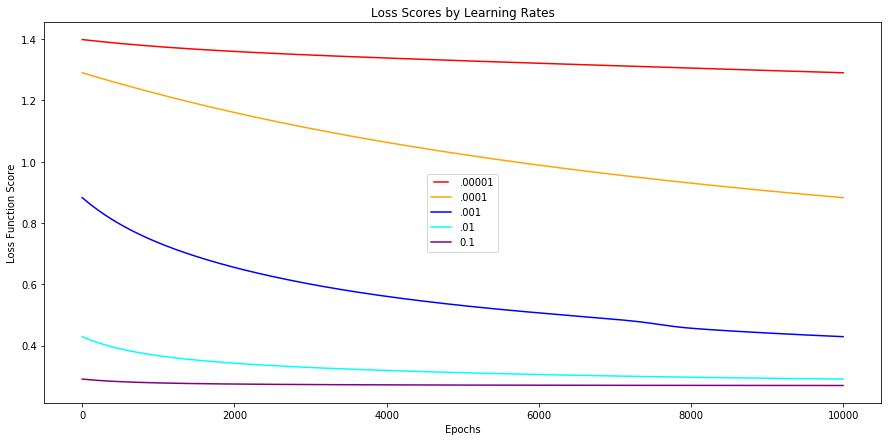

In [130]:
#plt.plot(bgd_losses_train[0:10000], color='red', label='.1')

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
plt.figure(figsize=(15,7))
line1, = plt.plot(bgd_losses_train[0:10000], color='red', label='.00001')
line2, = plt.plot(bgd_losses_train[10001:20000], color='orange', label='.0001')
line3, = plt.plot(bgd_losses_train[20001:30000], color='blue',label='.001')
line4, = plt.plot(bgd_losses_train[30001:40000], color='cyan',label='.01')
line5, = plt.plot(bgd_losses_train[40001:50000], color='purple',label='0.1')
#line6, = plt.plot(bgd_losses_train[50001:60000], color='pink',label='1')

plt.xlabel('Epochs')
plt.ylabel('Loss Function Score')
plt.title('Loss Scores by Learning Rates')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})


From the plot above, we see that the loss scores from a learning rate of 0.1 is lower than those of the other learning rates we tried.

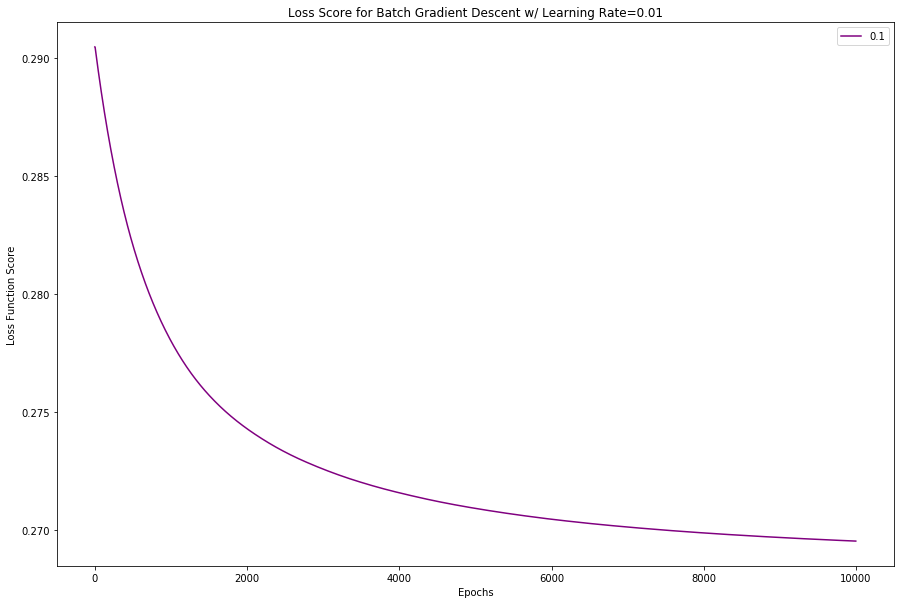

In [131]:
plt.figure(figsize=(15,10))

line5, = plt.plot(bgd_losses_train[40001:50000], color='purple',label='0.1')
plt.xlabel('Epochs')
plt.ylabel('Loss Function Score')
plt.title('Loss Score for Batch Gradient Descent w/ Learning Rate=0.01')


plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})


From the above, we see that a learning rate of .1 convereged to the lowest loss score of all of the different learning rates. Now we will remove the regularizer, but run the same learning rates on the training data.

In [56]:
hidden_nodes = 5
num_labels = 3
num_features = X_train.shape[1]
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2, .1, 1, 10]
#reg_lambda = .01
bgd_losses_train_noreg=[]

# Weights and Bias Arrays
layer1_weights_array = np.random.normal(0, 1, [num_features, hidden_nodes]) 
layer2_weights_array = np.random.normal(0, 1, [hidden_nodes, num_labels]) 

layer1_biases_array = np.zeros((1, hidden_nodes))
layer2_biases_array = np.zeros((1, num_labels))

for learning_rate in learning_rates:
    print ("\nTraining with learning rate:" + str(learning_rate))
   
    for step in range(0,n+1):

        input_layer = np.dot(X_train, layer1_weights_array)
        hidden_layer = relu_activation(input_layer + layer1_biases_array)
        output_layer = np.dot(hidden_layer, layer2_weights_array) + layer2_biases_array
        output_probs = softmax(output_layer)

        loss = cross_entropy_softmax_loss_array(output_probs, y_train_enc)
        loss += regularization_L2_softmax_loss(reg_lambda, layer1_weights_array, layer2_weights_array)

        output_error_signal = (output_probs - y_train_enc) / output_probs.shape[0]

        error_signal_hidden = np.dot(output_error_signal, layer2_weights_array.T) 
        error_signal_hidden[hidden_layer <= 0] = 0

        gradient_layer2_weights = np.dot(hidden_layer.T, output_error_signal)
        gradient_layer2_bias = np.sum(output_error_signal, axis = 0, keepdims = True)

        gradient_layer1_weights = np.dot(X_train.T, error_signal_hidden)
        gradient_layer1_bias = np.sum(error_signal_hidden, axis = 0, keepdims = True)

        #gradient_layer2_weights += reg_lambda * layer2_weights_array
        #gradient_layer1_weights += reg_lambda * layer1_weights_array

        layer1_weights_array -= learning_rate * gradient_layer1_weights
        layer1_biases_array -= learning_rate * gradient_layer1_bias
        layer2_weights_array -= learning_rate * gradient_layer2_weights
        layer2_biases_array -= learning_rate * gradient_layer2_bias

        bgd_losses_train_noreg.append(loss)
        
        if step % 500 == 0:
                print('Loss at step {0}: {1}'.format(step, loss))



Training with learning rate:1e-05
Loss at step 0: 3.0795645837006647
Loss at step 500: 3.005857137412311
Loss at step 1000: 2.9367075796315816
Loss at step 1500: 2.8717410348595167
Loss at step 2000: 2.8106863605096537
Loss at step 2500: 2.7532574940144605
Loss at step 3000: 2.6992000547341686
Loss at step 3500: 2.6482408264986117
Loss at step 4000: 2.60015152680113
Loss at step 4500: 2.5547046060014
Loss at step 5000: 2.511700328679273
Loss at step 5500: 2.4709389292028887
Loss at step 6000: 2.4322587595097955
Loss at step 6500: 2.3955214551939843
Loss at step 7000: 2.360603135447897
Loss at step 7500: 2.327372112136186
Loss at step 8000: 2.2957353124927664
Loss at step 8500: 2.2656174824050703
Loss at step 9000: 2.2369135360566323
Loss at step 9500: 2.2095532620660747
Loss at step 10000: 2.183469131866739

Training with learning rate:0.0001
Loss at step 0: 2.1834182164194877
Loss at step 500: 1.97983750087778
Loss at step 1000: 1.8477192945737368
Loss at step 1500: 1.754917741655635

C:\Users\Joan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
C:\Users\Joan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Joan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\Joan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in maximum
  
C:\Users\Joan\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in less_equal


Loss at step 500: nan
Loss at step 1000: nan
Loss at step 1500: nan
Loss at step 2000: nan
Loss at step 2500: nan
Loss at step 3000: nan
Loss at step 3500: nan
Loss at step 4000: nan
Loss at step 4500: nan
Loss at step 5000: nan
Loss at step 5500: nan
Loss at step 6000: nan
Loss at step 6500: nan
Loss at step 7000: nan
Loss at step 7500: nan
Loss at step 8000: nan
Loss at step 8500: nan
Loss at step 9000: nan
Loss at step 9500: nan
Loss at step 10000: nan


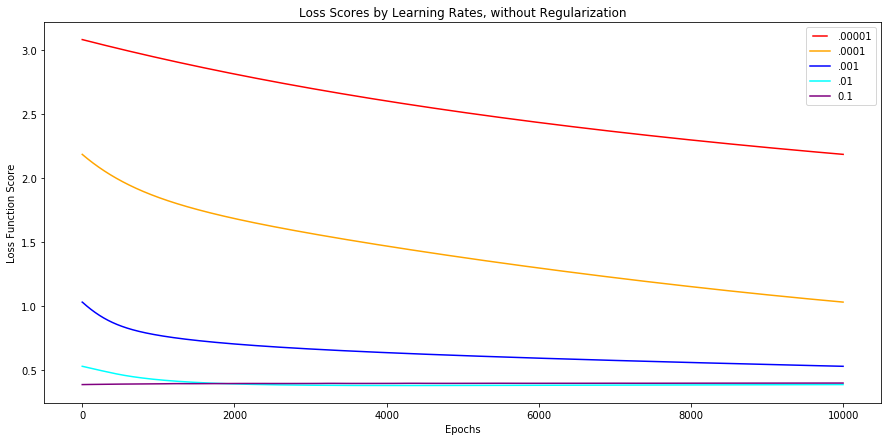

In [132]:
plt.figure(figsize=(15,7))
line1, = plt.plot(bgd_losses_train_noreg[0:10000], color='red', label='.00001')
line2, = plt.plot(bgd_losses_train_noreg[10001:20000], color='orange', label='.0001')
line3, = plt.plot(bgd_losses_train_noreg[20001:30000], color='blue',label='.001')
line4, = plt.plot(bgd_losses_train_noreg[30001:40000], color='cyan',label='.01')
line5, = plt.plot(bgd_losses_train_noreg[40001:50000], color='purple',label='0.1')
#line6, = plt.plot(bgd_losses_train_noreg[50001:60000], color='pink',label='1')

plt.xlabel('Epochs')
plt.ylabel('Loss Function Score')
plt.title('Loss Scores by Learning Rates, without Regularization')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})

Below, we will use a learning rate of 0.1, which yielded the lowest loss score from our exploration above; we will also use the regularization lambda value of .01, becuase also from the above, we saw that removing the regularizer did not yield lower loss scores than when we did use it.

In [85]:
hidden_nodes = 5
num_labels = 3
num_features = X_train.shape[1]
learning_rate = .1
reg_lambda = .01

bgd_losses =[]

# Weights and Bias Arrays
layer1_weights_array = np.random.normal(0, 1, [num_features, hidden_nodes]) 
layer2_weights_array = np.random.normal(0, 1, [hidden_nodes, num_labels]) 

layer1_biases_array = np.zeros((1, hidden_nodes))
layer2_biases_array = np.zeros((1, num_labels))

for step in range(0,n+1):

    input_layer = np.dot(X_train, layer1_weights_array)
    hidden_layer = relu_activation(input_layer + layer1_biases_array)
    output_layer = np.dot(hidden_layer, layer2_weights_array) + layer2_biases_array
    output_probs = softmax(output_layer)
    
    loss = cross_entropy_softmax_loss_array(output_probs, y_train_enc)
    loss += regularization_L2_softmax_loss(reg_lambda, layer1_weights_array, layer2_weights_array)

    output_error_signal = (output_probs - y_train_enc) / output_probs.shape[0]
    
    error_signal_hidden = np.dot(output_error_signal, layer2_weights_array.T) 
    error_signal_hidden[hidden_layer <= 0] = 0
    
    gradient_layer2_weights = np.dot(hidden_layer.T, output_error_signal)
    gradient_layer2_bias = np.sum(output_error_signal, axis = 0, keepdims = True)
    
    gradient_layer1_weights = np.dot(X_train.T, error_signal_hidden)
    gradient_layer1_bias = np.sum(error_signal_hidden, axis = 0, keepdims = True)

    gradient_layer2_weights += reg_lambda * layer2_weights_array
    gradient_layer1_weights += reg_lambda * layer1_weights_array

    layer1_weights_array -= learning_rate * gradient_layer1_weights
    layer1_biases_array -= learning_rate * gradient_layer1_bias
    layer2_weights_array -= learning_rate * gradient_layer2_weights
    layer2_biases_array -= learning_rate * gradient_layer2_bias
    
    bgd_losses.append(loss)
    
    if step % 500 == 0:
            print('Loss at step {0}: {1}'.format(step, loss))


Loss at step 0: 2.597404907119939
Loss at step 500: 0.319302472083167
Loss at step 1000: 0.28782248492181367
Loss at step 1500: 0.2807885366787253
Loss at step 2000: 0.2769541143911246
Loss at step 2500: 0.2747857616023409
Loss at step 3000: 0.273318202966768
Loss at step 3500: 0.27225697215106237
Loss at step 4000: 0.2714732854172388
Loss at step 4500: 0.2708618708654143
Loss at step 5000: 0.2703663368971549
Loss at step 5500: 0.2699618576479229
Loss at step 6000: 0.2696160116355575
Loss at step 6500: 0.2693206839038755
Loss at step 7000: 0.26906593037288884
Loss at step 7500: 0.2688516472444903
Loss at step 8000: 0.2686714887756547
Loss at step 8500: 0.26851817220526925
Loss at step 9000: 0.2683831760556877
Loss at step 9500: 0.26825960601820087
Loss at step 10000: 0.2681509548905604


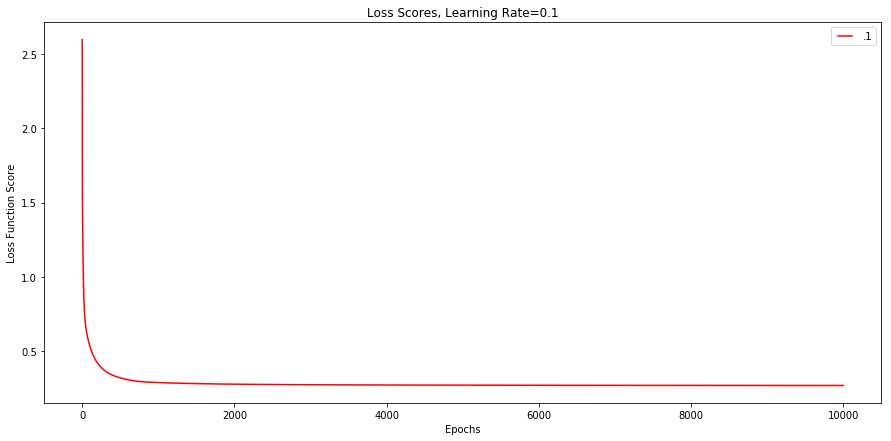

In [133]:
plt.figure(figsize=(15,7))
plt.xlabel('Epochs')
plt.ylabel('Loss Function Score')
plt.title('Loss Scores, Learning Rate=0.1')
line1, = plt.plot(bgd_losses, color='red', label='.1')
#line2, = plt.plot([1,2,3], marker='o', label='Line 2')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})

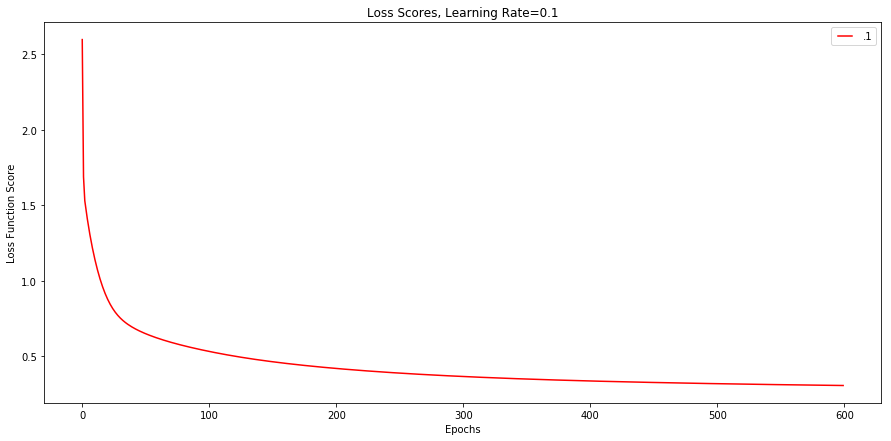

In [87]:
plt.figure(figsize=(15,7))
plt.xlabel('Epochs')
plt.ylabel('Loss Function Score')
plt.title('Loss Scores, Learning Rate=0.1')
line1, = plt.plot(bgd_losses[0:600], color='red', label='.1')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})


### Shape of some outputs

In [88]:
output_probs

array([[2.95209523e-10, 1.94924317e-03, 9.98050757e-01],
       [9.92119476e-01, 7.87216674e-03, 8.35698448e-06],
       [6.79226322e-06, 1.93527218e-01, 8.06465990e-01],
       ...,
       [9.75968669e-01, 2.39880264e-02, 4.33050076e-05],
       [2.54063924e-03, 9.43972867e-01, 5.34864941e-02],
       [4.52440248e-05, 4.27883990e-01, 5.72070766e-01]])

In [89]:
loss

0.2681509548905604

In [90]:
output_error_signal

array([[ 1.23003968e-14,  8.12184655e-08, -8.12184778e-08],
       [-3.28355155e-07,  3.28006948e-07,  3.48207687e-10],
       [ 2.83010967e-10,  8.06363408e-06, -8.06391709e-06],
       ...,
       [-1.00130548e-06,  9.99501101e-07,  1.80437532e-09],
       [ 1.05859968e-07, -2.33446389e-06,  2.22860392e-06],
       [ 1.88516770e-09,  1.78284996e-05, -1.78303847e-05]])

In [91]:
error_signal_hidden

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -7.00847205e-08],
       [ 0.00000000e+00, -1.07383129e-07, -4.48827257e-07,
        -4.60284017e-09,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         6.28440221e-06, -6.95880844e-06],
       ...,
       [ 0.00000000e+00, -3.27335293e-07, -1.36815578e-06,
        -1.46148421e-08,  1.15889999e-06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.73540652e-06,  1.80074094e-06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.38956591e-05, -1.53882993e-05]])

In [92]:
gradient_layer1_weights

array([[-1.00687047e-07, -8.66982090e-06, -5.52434672e-05,
        -2.59847057e-05, -4.68445348e-05],
       [-1.94557784e-07,  2.51064239e-05,  9.06964099e-05,
         8.05055184e-05,  2.77800349e-05]])

In [93]:
layer1_weights_array

array([[-1.00586360e-05,  9.03330950e-02,  3.86847105e-01,
        -5.50930051e-02, -1.95801661e-01],
       [-1.94363226e-05, -1.93623610e-01, -8.00805340e-01,
        -3.74397538e-01,  1.42060291e+00]])

# Predictions: Batch Gradient Descent

In [94]:
input_layer = np.dot(X_test, layer1_weights_array)
hidden_layer = relu_activation(input_layer + layer1_biases_array)
scores = np.dot(hidden_layer, layer2_weights_array) + layer2_biases_array
probs = softmax(scores)
print('Test accuracy: {0}%'.format(accuracy(probs, y_test_enc)))

Test accuracy: 90.98333333333333%


### Plot of predictions

Let's compare results.

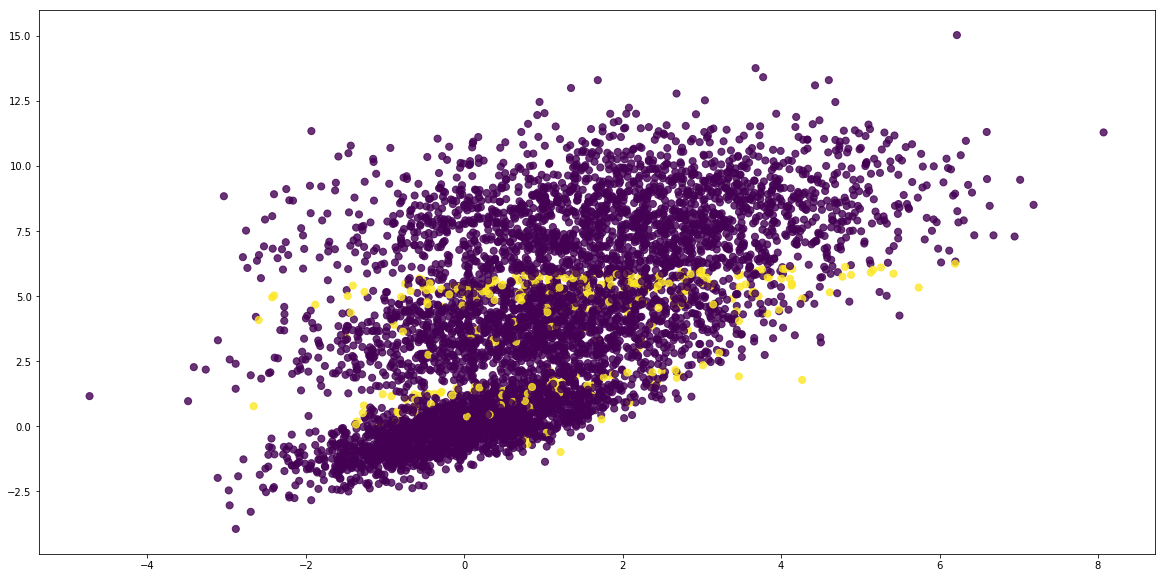

In [95]:
labels_flat = np.argmax(y_test_enc, axis = 1)
predictions = np.argmax(probs, axis = 1)
plt.figure(figsize = (20, 10))
plt.scatter(X_test[:, 0], X_test[:, 1], c = predictions == labels_flat - 1, alpha = .8, s = 50)

## Minibatch Gradient Descent

Training on the dataset in batches and updating the weights after each batch.

In [134]:
from sklearn.utils import shuffle

hidden_nodes = 5
num_labels = 3
num_features = X_train.shape[1]
learning_rate = 1e-2
reg_lambda = .01
minibatch_size = 256

# Weights and Bias Arrays
layer1_weights_array = np.random.normal(0, 1, [num_features, hidden_nodes]) 
layer2_weights_array = np.random.normal(0, 1, [hidden_nodes, num_labels]) 

layer1_biases_array = np.zeros((1, hidden_nodes))
layer2_biases_array = np.zeros((1, num_labels))

for step in range(0,n+1):
    
    X_train_rand, y_train_rand = shuffle(X_train, y_train_enc)
    
    step_loss = []
    
    #learning_rate *= 1/(1+0.01*1)
    
    # Get pair of (X, y) of the current minibatch/chunk
    for i in range(0, X_train.shape[0], minibatch_size):
        X_train_mini = X_train_rand[i:i + minibatch_size]
        y_train_mini = y_train_rand[i:i + minibatch_size]

        input_layer = np.dot(X_train_mini, layer1_weights_array)
        hidden_layer = relu_activation(input_layer + layer1_biases_array)
        output_layer = np.dot(hidden_layer, layer2_weights_array) + layer2_biases_array
        output_probs = softmax(output_layer)

        loss = cross_entropy_softmax_loss_array(output_probs, y_train_mini)
        loss += regularization_L2_softmax_loss(reg_lambda, layer1_weights_array, layer2_weights_array)
        step_loss.append(loss)

        output_error_signal = (output_probs - y_train_mini) / output_probs.shape[0]

        error_signal_hidden = np.dot(output_error_signal, layer2_weights_array.T) 
        error_signal_hidden[hidden_layer <= 0] = 0

        gradient_layer2_weights = np.dot(hidden_layer.T, output_error_signal)
        gradient_layer2_bias = np.sum(output_error_signal, axis = 0, keepdims = True)

        gradient_layer1_weights = np.dot(X_train_mini.T, error_signal_hidden)
        gradient_layer1_bias = np.sum(error_signal_hidden, axis = 0, keepdims = True)

        gradient_layer2_weights += reg_lambda * layer2_weights_array
        gradient_layer1_weights += reg_lambda * layer1_weights_array

        layer1_weights_array -= learning_rate * gradient_layer1_weights
        layer1_biases_array -= learning_rate * gradient_layer1_bias
        layer2_weights_array -= learning_rate * gradient_layer2_weights
        layer2_biases_array -= learning_rate * gradient_layer2_bias
        

    if step % 500 == 0:
            print('Loss at step {0}: {1}'.format(step, loss))
            #print learning_rate

Loss at step 0: 0.7928676110597779
Loss at step 500: 0.2757978794111591
Loss at step 1000: 0.2189762262097522
Loss at step 1500: 0.23843089771997633
Loss at step 2000: 0.2857677605633773
Loss at step 2500: 0.2838835274880642
Loss at step 3000: 0.2826854599932771
Loss at step 3500: 0.27367576387546816
Loss at step 4000: 0.279502794410358
Loss at step 4500: 0.336974599873442
Loss at step 5000: 0.23450852327097482
Loss at step 5500: 0.25572548931340383
Loss at step 6000: 0.24163490321292835
Loss at step 6500: 0.26902033608904546
Loss at step 7000: 0.29821776672330136
Loss at step 7500: 0.2240181900483596
Loss at step 8000: 0.2808029631330577
Loss at step 8500: 0.25376962851804863
Loss at step 9000: 0.24646571001653075
Loss at step 9500: 0.23968278903883025
Loss at step 10000: 0.27294948957206583


## Minibatch Gradient Descent: tuning learning rate

In [114]:

hidden_nodes = 5
num_labels = 3
num_features = X_train.shape[1]
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2, .1]
#learning_rate = 1e-2
reg_lambda = .01
minibatch_size = 256

mbgd_losses_train = []

# Weights and Bias Arrays
layer1_weights_array = np.random.normal(0, 1, [num_features, hidden_nodes]) 
layer2_weights_array = np.random.normal(0, 1, [hidden_nodes, num_labels]) 

layer1_biases_array = np.zeros((1, hidden_nodes))
layer2_biases_array = np.zeros((1, num_labels))

for learning_rate in learning_rates:
    print ("\nTraining with learning rate:" + str(learning_rate))
    
    for step in range(0,n+1):

        X_train_rand, y_train_rand = shuffle(X_train, y_train_enc)

        step_loss = []

        #learning_rate *= 1/(1+0.01*1)

        # Get pair of (X, y) of the current minibatch/chunk
        for i in range(0, X_train.shape[0], minibatch_size):
            X_train_mini = X_train_rand[i:i + minibatch_size]
            y_train_mini = y_train_rand[i:i + minibatch_size]

            input_layer = np.dot(X_train_mini, layer1_weights_array)
            hidden_layer = relu_activation(input_layer + layer1_biases_array)
            output_layer = np.dot(hidden_layer, layer2_weights_array) + layer2_biases_array
            output_probs = softmax(output_layer)

            loss = cross_entropy_softmax_loss_array(output_probs, y_train_mini)
            loss += regularization_L2_softmax_loss(reg_lambda, layer1_weights_array, layer2_weights_array)
            step_loss.append(loss)

            output_error_signal = (output_probs - y_train_mini) / output_probs.shape[0]

            error_signal_hidden = np.dot(output_error_signal, layer2_weights_array.T) 
            error_signal_hidden[hidden_layer <= 0] = 0

            gradient_layer2_weights = np.dot(hidden_layer.T, output_error_signal)
            gradient_layer2_bias = np.sum(output_error_signal, axis = 0, keepdims = True)

            gradient_layer1_weights = np.dot(X_train_mini.T, error_signal_hidden)
            gradient_layer1_bias = np.sum(error_signal_hidden, axis = 0, keepdims = True)

            gradient_layer2_weights += reg_lambda * layer2_weights_array
            gradient_layer1_weights += reg_lambda * layer1_weights_array

            layer1_weights_array -= learning_rate * gradient_layer1_weights
            layer1_biases_array -= learning_rate * gradient_layer1_bias
            layer2_weights_array -= learning_rate * gradient_layer2_weights
            layer2_biases_array -= learning_rate * gradient_layer2_bias

        mbgd_losses_train.append(np.average(step_loss))
        if step % 500 == 0:
                print('Loss at step {0}: {1}'.format(step, loss))
                #print learning_rate
        



Training with learning rate:1e-05
Loss at step 0: 11.453009476180249
Loss at step 500: 1.1387929198500533
Loss at step 1000: 0.9388082294446298
Loss at step 1500: 0.8402972823129855
Loss at step 2000: 0.7875513487921946
Loss at step 2500: 0.7689266214775833
Loss at step 3000: 0.7145216522589226
Loss at step 3500: 0.7078768977846752
Loss at step 4000: 0.670011757075923
Loss at step 4500: 0.6526292539696164
Loss at step 5000: 0.6457470619943385
Loss at step 5500: 0.6350378770292521
Loss at step 6000: 0.6214324820732045
Loss at step 6500: 0.5937785762568272
Loss at step 7000: 0.5595436530246953
Loss at step 7500: 0.5796649472567913
Loss at step 8000: 0.5394923696810008
Loss at step 8500: 0.5376282707873741
Loss at step 9000: 0.5270523754600183
Loss at step 9500: 0.5218145056288357
Loss at step 10000: 0.47135633920823494

Training with learning rate:0.0001
Loss at step 0: 0.5231899692417764
Loss at step 500: 0.45701916560956096
Loss at step 1000: 0.4274007718398707
Loss at step 1500: 0.41

In [138]:
mbgd_losses_train[20001]

0.2968499873463803

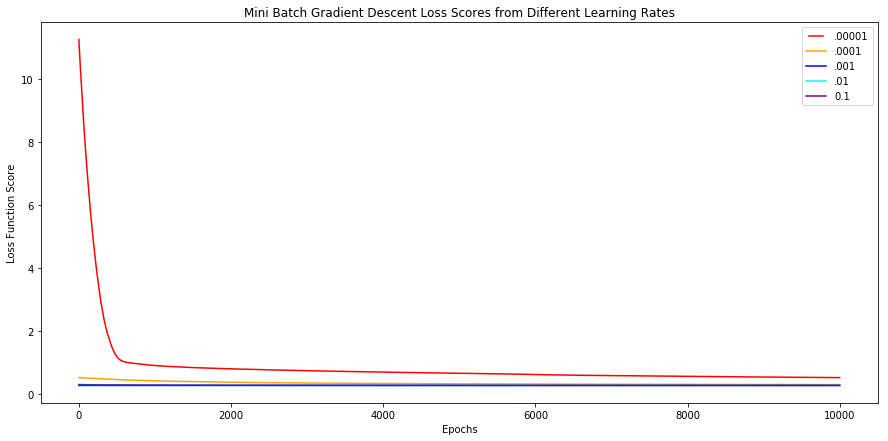

In [139]:
plt.figure(figsize=(15,7))
line1, = plt.plot(mbgd_losses_train[0:10000], color='red', label='.00001')
line2, = plt.plot(mbgd_losses_train[10001:20000], color='orange', label='.0001')
line3, = plt.plot(mbgd_losses_train[20001:30000], color='blue',label='.001')
line4, = plt.plot(mbgd_losses_train[30001:40000], color='cyan',label='.01')
line5, = plt.plot(mbgd_losses_train[40001:50000], color='purple',label='0.1')

plt.xlabel('Epochs')
plt.ylabel('Loss Function Score')
plt.title('Mini Batch Gradient Descent Loss Scores from Different Learning Rates')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})


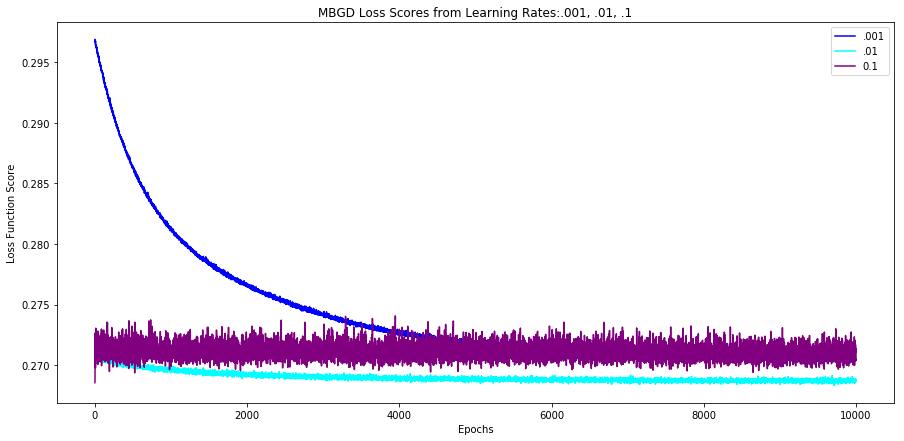

In [141]:
#plotting the loss scores for the three learning rates with lowest loss scores
plt.figure(figsize=(15,7))
#line1, = plt.plot(mbgd_losses_train[0:10000], color='red', label='.00001')
#line2, = plt.plot(mbgd_losses_train[10001:20000], color='orange', label='.0001')
line3, = plt.plot(mbgd_losses_train[20001:30000], color='blue',label='.001')
line4, = plt.plot(mbgd_losses_train[30001:40000], color='cyan',label='.01')
line5, = plt.plot(mbgd_losses_train[40001:50000], color='purple',label='0.1')

plt.xlabel('Epochs')
plt.ylabel('Loss Function Score')
plt.title('MBGD Loss Scores from Learning Rates:.001, .01, .1')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})

As we can see from the graph above, a learning rate of .01 has a lower loss score than 1e-1 or 1e-3, so we will use this to train our model.

In [161]:
hidden_nodes = 5
num_labels = 3
num_features = X_train.shape[1]
learning_rate = 1e-2
reg_lambda = .01
minibatch_size = 256

mbgd_losses = []

# Weights and Bias Arrays
layer1_weights_array = np.random.normal(0, 1, [num_features, hidden_nodes]) 
layer2_weights_array = np.random.normal(0, 1, [hidden_nodes, num_labels]) 

layer1_biases_array = np.zeros((1, hidden_nodes))
layer2_biases_array = np.zeros((1, num_labels))

for step in range(0,n+1):
    
    X_train_rand, y_train_rand = shuffle(X_train, y_train_enc)
    
    step_loss = []
    
    #learning_rate *= 1/(1+0.01*1)
    
    # Get pair of (X, y) of the current minibatch/chunk
    for i in range(0, X_train.shape[0], minibatch_size):
        X_train_mini = X_train_rand[i:i + minibatch_size]
        y_train_mini = y_train_rand[i:i + minibatch_size]

        input_layer = np.dot(X_train_mini, layer1_weights_array)
        hidden_layer = relu_activation(input_layer + layer1_biases_array)
        output_layer = np.dot(hidden_layer, layer2_weights_array) + layer2_biases_array
        output_probs = softmax(output_layer)

        loss = cross_entropy_softmax_loss_array(output_probs, y_train_mini)
        loss += regularization_L2_softmax_loss(reg_lambda, layer1_weights_array, layer2_weights_array)
        step_loss.append(loss)

        output_error_signal = (output_probs - y_train_mini) / output_probs.shape[0]

        error_signal_hidden = np.dot(output_error_signal, layer2_weights_array.T) 
        error_signal_hidden[hidden_layer <= 0] = 0

        gradient_layer2_weights = np.dot(hidden_layer.T, output_error_signal)
        gradient_layer2_bias = np.sum(output_error_signal, axis = 0, keepdims = True)

        gradient_layer1_weights = np.dot(X_train_mini.T, error_signal_hidden)
        gradient_layer1_bias = np.sum(error_signal_hidden, axis = 0, keepdims = True)

        gradient_layer2_weights += reg_lambda * layer2_weights_array
        gradient_layer1_weights += reg_lambda * layer1_weights_array

        layer1_weights_array -= learning_rate * gradient_layer1_weights
        layer1_biases_array -= learning_rate * gradient_layer1_bias
        layer2_weights_array -= learning_rate * gradient_layer2_weights
        layer2_biases_array -= learning_rate * gradient_layer2_bias
        
    mbgd_losses.append(np.average(step_loss))

    if step % 500 == 0:
            print('Loss at step {0}: {1}'.format(step, loss))
            #print learning_rate


Loss at step 0: 1.1454158832083037
Loss at step 500: 0.294585958509636
Loss at step 1000: 0.3116335824435408
Loss at step 1500: 0.28934454695524436
Loss at step 2000: 0.31012608320315116
Loss at step 2500: 0.235013504309879
Loss at step 3000: 0.2879006323640576
Loss at step 3500: 0.2381772034451577
Loss at step 4000: 0.2881818823557598
Loss at step 4500: 0.24630569346141357
Loss at step 5000: 0.238608074959873
Loss at step 5500: 0.327823332428822
Loss at step 6000: 0.2529592749383129
Loss at step 6500: 0.26352929142789516
Loss at step 7000: 0.27220393281660576
Loss at step 7500: 0.30212316241663023
Loss at step 8000: 0.24423290451882812
Loss at step 8500: 0.2895480077517357
Loss at step 9000: 0.26668882496756463
Loss at step 9500: 0.3029277010459382
Loss at step 10000: 0.22569533459187044


# Predictions: Minibatch Gradient Descent

In [162]:
input_layer = np.dot(X_test, layer1_weights_array)
hidden_layer = relu_activation(input_layer + layer1_biases_array)
scores = np.dot(hidden_layer, layer2_weights_array) + layer2_biases_array
probs = softmax(scores)
print('Test accuracy: {0}%'.format(accuracy(probs, y_test_enc)))

Test accuracy: 90.93333333333334%


### Results with various parameters for mini batch


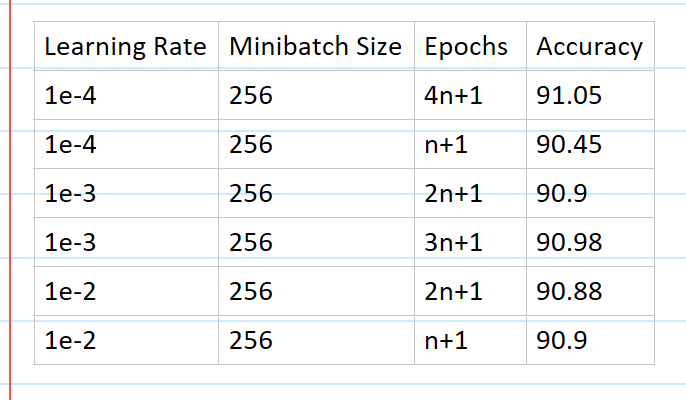

In [61]:
Image("../optimization_final/raw/minibatch_param_accuracies.png")

#### Adagrad
$G^{k} = G^{k−1} + ∇J(θ^{k−1})^2$<br>
$θ^{k} = θ^{k−1} – α / sqrt(G^{k−1}) * ∇J(θ^{k−1})$

In [142]:
from random import sample
import math
def adagrad(f_grad,
            x0,
            data,
            args,
            stepsize = 1e-2, 
            fudge_factor = 1e-6, 
            max_it=1000, 
            minibatchsize=None, 
            minibatch_ratio=0.01):
    # f_grad returns the loss functions gradient
    # x0 are the initial parameters (a starting point for the optimization)
    # data is a list of training data
    # args is a list or tuple of additional arguments passed to fgrad
    # stepsize is the global stepsize fir adagrad
    # fudge_factor is a small number to counter numerical instabiltiy
    # max_it is the number of iterations adagrad will run
    # minibatchsize if given is the number of training samples considered in each iteration
    # minibatch_ratio if minibatchsize is not set this ratio will be used to determine the batch size dependent on the length of the training data
    
    #d-dimensional vector representing diag(Gt) to store a running total of the squares of the gradients.
    gti = np.zeros(x0.shape[0])
    
    ld = len(data)
    if minibatchsize is None:
        minibatchsize = int(math.ceil(len(data)*minibatch_ratio))
    w = x0
    for t in range(max_it):
        s = sample(xrange(ld), minibatchsize)
        sd = [data[idx] for idx in s]
        grad = f_grad(w, sd, *args)
        gti += grad**2
        adjusted_grad = grad / (fudge_factor + np.sqrt(gti))
        w = w - stepsize*adjusted_grad
    return w


In [143]:
adagrad(f_grad=, x0=, data=, args=)

SyntaxError: invalid syntax (<ipython-input-143-ff8ba198198e>, line 1)

In [144]:
hidden_nodes = 5
num_labels = 3
num_features = X_train.shape[1]
learning_rate = .01
reg_lambda = .01

gti = X_train.shape[0]

# Weights and Bias Arrays
layer1_weights_array = np.random.normal(0, 1, [num_features, hidden_nodes]) 
layer2_weights_array = np.random.normal(0, 1, [hidden_nodes, num_labels]) 

layer1_biases_array = np.zeros((1, hidden_nodes))
layer2_biases_array = np.zeros((1, num_labels))

w = layer1_weights_array

for step in range(0,n+1):

    input_layer = np.dot(X_train, w)
    hidden_layer = relu_activation(input_layer + layer1_biases_array)
    output_layer = np.dot(hidden_layer, layer2_weights_array) + layer2_biases_array
    output_probs = softmax(output_layer)
    
    loss = cross_entropy_softmax_loss_array(output_probs, y_train_enc)
    grad = regularization_L2_softmax_loss(reg_lambda, w, layer2_weights_array)
    loss += grad
    
    gti += grad**2
    adjusted_grad = grad / np.sqrt(gti)
    w = w - learning_rate*adjusted_grad

    output_error_signal = (output_probs - y_train_enc) / output_probs.shape[0]
    
    error_signal_hidden = np.dot(output_error_signal, layer2_weights_array.T) 
    error_signal_hidden[hidden_layer <= 0] = 0
    
    gradient_layer2_weights = np.dot(hidden_layer.T, output_error_signal)
    gradient_layer2_bias = np.sum(output_error_signal, axis = 0, keepdims = True)
    
    gradient_layer1_weights = np.dot(X_train.T, error_signal_hidden)
    gradient_layer1_bias = np.sum(error_signal_hidden, axis = 0, keepdims = True)

    gradient_layer2_weights += reg_lambda * layer2_weights_array
    gradient_layer1_weights += reg_lambda * w

    w -= learning_rate * gradient_layer1_weights
    layer1_biases_array -= learning_rate * gradient_layer1_bias
    layer2_weights_array -= learning_rate * gradient_layer2_weights
    layer2_biases_array -= learning_rate * gradient_layer2_bias
    
    if step % 500 == 0:
            print('Loss at step {0}: {1}'.format(step, loss))
            #print('Adagrad parameters are step {0}: {1}'.format(step, w))


Loss at step 0: 9.774417255318182
Adagrad parameters are step 0: [[-0.49466115 -0.62924103  2.41101163  0.35102619 -1.25653667]
 [ 0.89473894  0.26154393 -0.57715943  0.69923185 -0.18569498]]
Loss at step 500: 0.4842397488241201
Adagrad parameters are step 500: [[-0.18158392 -0.46215978  2.10632974  0.38215436 -1.26096336]
 [ 0.50206235  0.88980408 -0.30884601  0.00703816 -0.33144339]]
Loss at step 1000: 0.40490865651002406
Adagrad parameters are step 1000: [[-0.06612633 -0.47876395  1.98183339  0.32817773 -1.20813003]
 [ 0.49113587  0.90790648 -0.25222121 -0.12164582 -0.33969423]]
Loss at step 1500: 0.3736571399365923
Adagrad parameters are step 1500: [[-0.03279424 -0.48910449  1.8764055   0.29082247 -1.14968025]
 [ 0.48941607  0.92620464 -0.22142607 -0.17347706 -0.33695652]]
Loss at step 2000: 0.35674935417127185
Adagrad parameters are step 2000: [[-0.02530703 -0.49593018  1.78058035  0.26146814 -1.09151887]
 [ 0.49794312  0.95084007 -0.19865679 -0.19664197 -0.33336578]]
Loss at step

## Adagrad: tuning learning rate

In [170]:
hidden_nodes = 5
num_labels = 3
num_features = X_train.shape[1]
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2, .1, 1]
reg_lambda = .01

adag_losses_train=[]

gti = X_train.shape[0]

# Weights and Bias Arrays
layer1_weights_array = np.random.normal(0, 1, [num_features, hidden_nodes]) 
layer2_weights_array = np.random.normal(0, 1, [hidden_nodes, num_labels]) 

layer1_biases_array = np.zeros((1, hidden_nodes))
layer2_biases_array = np.zeros((1, num_labels))

w = layer1_weights_array

for learning_rate in learning_rates:
    print ("\nTraining with learning rate:" + str(learning_rate))
    
    for step in range(0,n+1):

        input_layer = np.dot(X_train, w)
        hidden_layer = relu_activation(input_layer + layer1_biases_array)
        output_layer = np.dot(hidden_layer, layer2_weights_array) + layer2_biases_array
        output_probs = softmax(output_layer)

        loss = cross_entropy_softmax_loss_array(output_probs, y_train_enc)
        grad = regularization_L2_softmax_loss(reg_lambda, w, layer2_weights_array)
        loss += grad

        gti += grad**2
        adjusted_grad = grad / np.sqrt(gti)
        w = w - learning_rate*adjusted_grad

        output_error_signal = (output_probs - y_train_enc) / output_probs.shape[0]

        error_signal_hidden = np.dot(output_error_signal, layer2_weights_array.T) 
        error_signal_hidden[hidden_layer <= 0] = 0

        gradient_layer2_weights = np.dot(hidden_layer.T, output_error_signal)
        gradient_layer2_bias = np.sum(output_error_signal, axis = 0, keepdims = True)

        gradient_layer1_weights = np.dot(X_train.T, error_signal_hidden)
        gradient_layer1_bias = np.sum(error_signal_hidden, axis = 0, keepdims = True)

        gradient_layer2_weights += reg_lambda * layer2_weights_array
        gradient_layer1_weights += reg_lambda * w

        w -= learning_rate * gradient_layer1_weights
        layer1_biases_array -= learning_rate * gradient_layer1_bias
        layer2_weights_array -= learning_rate * gradient_layer2_weights
        layer2_biases_array -= learning_rate * gradient_layer2_bias

        adag_losses_train.append(loss)

        if step % 500 == 0:
                print('Loss at step {0}: {1}'.format(step, loss))
                #print('Adagrad parameters are step {0}: {1}'.format(step, w))



Training with learning rate:1e-05
Loss at step 0: 7.106657315906666
Loss at step 500: 6.739916451562437
Loss at step 1000: 6.393858148080367
Loss at step 1500: 6.067783479086218
Loss at step 2000: 5.761473224972711
Loss at step 2500: 5.4735485027844275
Loss at step 3000: 5.203341389625561
Loss at step 3500: 4.950499888221598
Loss at step 4000: 4.714533186889113
Loss at step 4500: 4.4947868471729375
Loss at step 5000: 4.290686884573908
Loss at step 5500: 4.101732867695781
Loss at step 6000: 3.927319190191246
Loss at step 6500: 3.766746964260266
Loss at step 7000: 3.6194058936144287
Loss at step 7500: 3.4841275030425725
Loss at step 8000: 3.3599954256572424
Loss at step 8500: 3.2461385199113426
Loss at step 9000: 3.1414755440010467
Loss at step 9500: 3.04503340836821
Loss at step 10000: 2.955905999313157

Training with learning rate:0.0001
Loss at step 0: 2.955734551834312
Loss at step 500: 2.3214972173023947
Loss at step 1000: 1.9093990094859365
Loss at step 1500: 1.594001959142702
Los

In [171]:
adag_losses_train[10001]

2.955734551834312

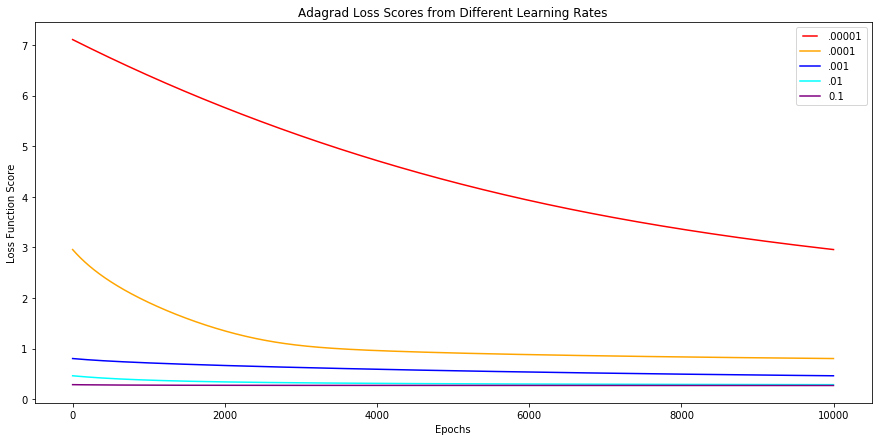

In [173]:
plt.figure(figsize=(15,7))
line1, = plt.plot(adag_losses_train[0:10000], color='red', label='.00001')
line2, = plt.plot(adag_losses_train[10001:20000], color='orange', label='.0001')
line3, = plt.plot(adag_losses_train[20001:30000], color='blue',label='.001')
line4, = plt.plot(adag_losses_train[30001:40000], color='cyan',label='.01')
line5, = plt.plot(adag_losses_train[40001:50000], color='purple',label='0.1')
#line6, = plt.plot(adag_losses_train[50001:60000], color='pink',label='1.0')

plt.xlabel('Epochs')
plt.ylabel('Loss Function Score')
plt.title('Adagrad Loss Scores from Different Learning Rates')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})

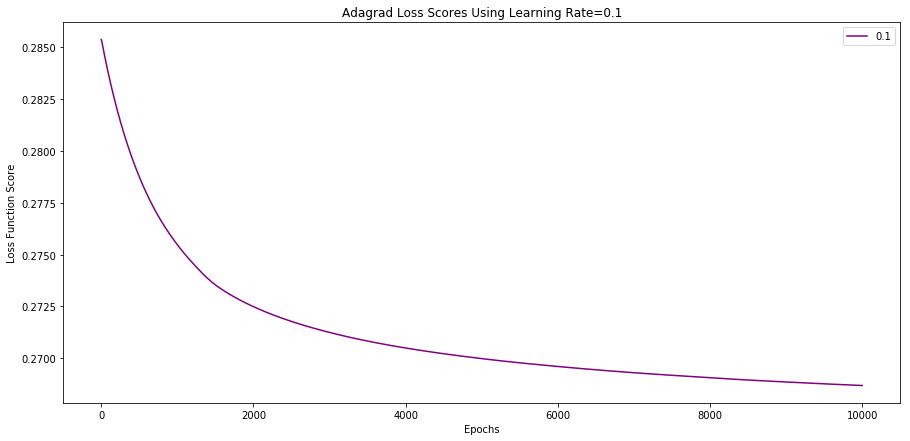

In [174]:
plt.figure(figsize=(15,7))
#line1, = plt.plot(adag_losses_train[0:10000], color='red', label='.00001')
#line2, = plt.plot(adag_losses_train[10001:20000], color='orange', label='.0001')
#line3, = plt.plot(adag_losses_train[20001:30000], color='blue',label='.001')
#line4, = plt.plot(adag_losses_train[30001:40000], color='cyan',label='.01')
line5, = plt.plot(adag_losses_train[40001:50000], color='purple',label='0.1')

plt.xlabel('Epochs')
plt.ylabel('Loss Function Score')
plt.title('Adagrad Loss Scores Using Learning Rate=0.1')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})

From the learning rate tuning and plots above, we see that a learning rate of 0.1 with the Adagrad optimizer yielded the lowest loss scores with our training data. We will run that learning rate once more on our training data before running our validation set.

In [190]:
hidden_nodes = 5
num_labels = 3
num_features = X_train.shape[1]
learning_rate = .1
reg_lambda = .01

gti = X_train.shape[0]

adag_losses=[]

# Weights and Bias Arrays
layer1_weights_array = np.random.normal(0, 1, [num_features, hidden_nodes]) 
layer2_weights_array = np.random.normal(0, 1, [hidden_nodes, num_labels]) 

layer1_biases_array = np.zeros((1, hidden_nodes))
layer2_biases_array = np.zeros((1, num_labels))

w = layer1_weights_array

for step in range(0,n+1):

    input_layer = np.dot(X_train, w)
    hidden_layer = relu_activation(input_layer + layer1_biases_array)
    output_layer = np.dot(hidden_layer, layer2_weights_array) + layer2_biases_array
    output_probs = softmax(output_layer)
    
    loss = cross_entropy_softmax_loss_array(output_probs, y_train_enc)
    grad = regularization_L2_softmax_loss(reg_lambda, w, layer2_weights_array)
    loss += grad
    
    gti += grad**2
    adjusted_grad = grad / np.sqrt(gti)
    w = w - learning_rate*adjusted_grad

    output_error_signal = (output_probs - y_train_enc) / output_probs.shape[0]
    
    error_signal_hidden = np.dot(output_error_signal, layer2_weights_array.T) 
    error_signal_hidden[hidden_layer <= 0] = 0
    
    gradient_layer2_weights = np.dot(hidden_layer.T, output_error_signal)
    gradient_layer2_bias = np.sum(output_error_signal, axis = 0, keepdims = True)
    
    gradient_layer1_weights = np.dot(X_train.T, error_signal_hidden)
    gradient_layer1_bias = np.sum(error_signal_hidden, axis = 0, keepdims = True)

    gradient_layer2_weights += reg_lambda * layer2_weights_array
    gradient_layer1_weights += reg_lambda * w

    w -= learning_rate * gradient_layer1_weights
    layer1_biases_array -= learning_rate * gradient_layer1_bias
    layer2_weights_array -= learning_rate * gradient_layer2_weights
    layer2_biases_array -= learning_rate * gradient_layer2_bias
    
    adag_losses.append(loss)
    
    if step % 500 == 0:
            print('Loss at step {0}: {1}'.format(step, loss))
            print('Adagrad parameters are step {0}: {1}'.format(step, w))


Loss at step 0: 1.4986211544332757
Adagrad parameters are step 0: [[ 0.37619128 -0.59596558 -1.24495908  0.36517989 -0.23357623]
 [-0.62083325  0.79891339  0.6170741   0.01182456 -0.02225112]]
Loss at step 500: 0.3016731116216687
Adagrad parameters are step 500: [[ 0.13447346 -0.21157424 -0.34251455  0.05864002 -0.26108928]
 [-0.60701605  0.58754531  1.15587134 -0.10505762  0.13471436]]
Loss at step 1000: 0.28413112683480796
Adagrad parameters are step 1000: [[ 0.20405814 -0.1297212  -0.2959959   0.02252494 -0.18460876]
 [-0.71090576  0.58511211  1.18568826 -0.07639264  0.06002209]]
Loss at step 1500: 0.27746717412964644
Adagrad parameters are step 1500: [[ 0.24617042 -0.09633863 -0.27788911  0.00309159 -0.14379854]
 [-0.7742803   0.60686948  1.20181971 -0.05690034 -0.00686627]]
Loss at step 2000: 0.2742733986027966
Adagrad parameters are step 2000: [[ 0.27009841 -0.08146819 -0.27094586 -0.00769966 -0.12318122]
 [-0.81130306  0.63113402  1.21133797 -0.0440785  -0.06762373]]
Loss at ste

# Predictions: Adagrad

# Comparing our optimizers

Comparing the three optimizers based on performance on training data and best learning rate.

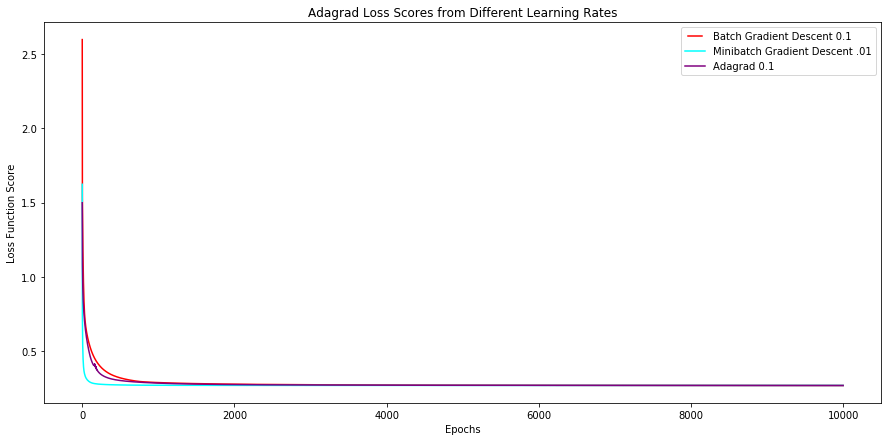

In [192]:
plt.figure(figsize=(15,7))
line1, = plt.plot(bgd_losses, color='red',label='Batch Gradient Descent 0.1')
line2, = plt.plot(mbgd_losses, color='cyan',label='Minibatch Gradient Descent .01')
line3, = plt.plot(adag_losses, color='purple',label='Adagrad 0.1')

plt.xlabel('Epochs')
plt.ylabel('Loss Function Score')
plt.title('Adagrad Loss Scores from Different Learning Rates')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})

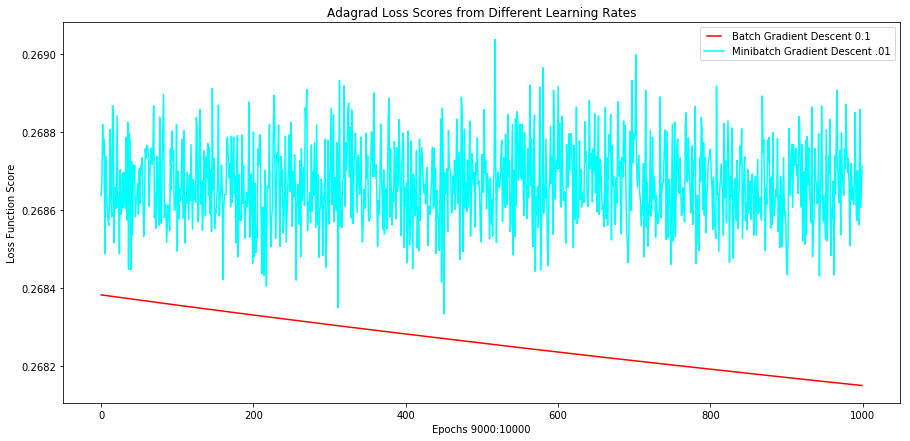

In [194]:
plt.figure(figsize=(15,7))
line1, = plt.plot(bgd_losses[9000:10000], color='red',label='Batch Gradient Descent 0.1')
line2, = plt.plot(mbgd_losses[9000:10000], color='cyan',label='Minibatch Gradient Descent .01')
#line3, = plt.plot(adag_losses[9000:10000], color='purple',label='Adagrad 0.1')

plt.xlabel('Epochs 9000:10000')
plt.ylabel('Loss Function Score')
plt.title('Adagrad Loss Scores from Different Learning Rates')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})

# Testing stock versions

We'd like to compare our results to a stock version of SGD.

We'll create a keras nn with 5 hidden nodes as we've done in the hard coded example.

### Setting parameters to match hand coded full batch gradient descent

In the neural network terminology:

one epoch = one forward pass and one backward pass of all the training examples

batch size = the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need.

number of iterations = number of passes, each pass using [batch size] number of examples. To be clear, one pass = one forward pass + one backward pass (we do not count the forward pass and backward pass as two different passes).

Example: if you have 1000 training examples, and your batch size is 500, then it will take 2 iterations to complete 1 epoch.

The below uses the full dataset as the batch size and n+1 as the number of epochs, matching the full batch gradient descent hand coded above. Time to convergence is TBD but upwards of 20 minutes.

In [176]:
n=10000

# define baseline model
def nn_model():
    # create model
    model = Sequential()
    model.add(Dense(5, input_dim=2, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model

In [177]:
estimator = KerasClassifier(build_fn=nn_model,epochs = n, batch_size = len(X_train), verbose = 0)

In [178]:
%time estimator.fit(X_train,y_train)

Wall time: 6min 48s


In [179]:
print("Accuracy of NN on test: ", estimator.score(X_test,y_test))

Accuracy of NN on test:  0.9083333611488342
